In [1]:
import numpy as np
import random as rnd
from matplotlib import pyplot as plt

In [172]:
class Garnet:
    
    def __init__(self, Ns, Na, Nb, d, gamma):
        self.Ns = Ns # number of states
        self.Na = Na # number of actions in each state
        self.Nb = Nb # branching factor
        self.d = d   # dimension of feature vector
        self.gamma = gamma # discount factor
        self.initGarnet()
    
    # initialize garnet
    def initGarnet(self):
        self.initTransition()
        self.initReward()
        self.initPi()
        self.initPhi()
        
    def initFromGarnet(self, g):
        
        self.Ns = g.Ns
        self.Na = g.Na
        self.Nb = g.Nb
        self.d = g.d
        self.gamma = g.gamma
        self.P = g.P.copy()
        self.R = g.R.copy()
        self.pi = g.pi.copy()
        self.Phi = g.Phi.copy()
        self.w = g.w.copy()
        
        
    #------------------------   
    # initializers
    def initTransition(self):
        P = np.zeros((self.Ns, self.Na, self.Ns))
        for i in range(self.Ns):
            for j in range(self.Na):
                sampleArr = rnd.sample(range(self.Ns), k = self.Nb)
                P_sum = np.random.rand(self.Nb - 1)
                P_sum = np.sort([*P_sum, 0, 1])
                for k in range(self.Nb):
                    P[i][j][sampleArr[k]] = P_sum[k + 1] - P_sum[k]
        self.P = P                                            # P: s x a x s'
    
    def initReward(self):
        self.R = np.random.uniform(size=(self.Ns, self.Na))   # R: s x a
    
    def initPi(self):
        # uniform random
        self.pi = np.ones((self.Ns, self.Na)) / self.Na    # pi: s x a
        
    def initPhi(self, mean=1):
        self.Phi = np.random.normal(loc=mean,size=(self.Ns, self.Na, self.d))  # phi: s x a x d
        self.w = np.zeros((self.d,1))  # w (weight vector): d x 1
        self.calPolicy()
    
    #------------------------
    # generate sequence
    def getNext(self, s):
        a = self.getAction(s)
        r = self.R[s,a]
        s_next = self.getState(s,a)
        return a, r, s_next
    
    def getAction(self, s):
        try:
            return np.random.choice(np.arange(self.Na),p=self.pi[s,:])
        except:
            raise ValueError("s:{}".format(s))
    
    def getState(self, s, a):
        return np.random.choice(np.arange(self.Ns), p=self.P[s,a,:])
    
    #------------------------   
    # cal & store true state values given a policy
    def calValue(self):   
        # works for different pi
        P_pi = np.einsum('ijk,ij->ik', self.P, self.pi)  # P_pi: s x s'
        R_pi = np.einsum('ij,ij->i', self.pi, self.R)    # R_pi: s x 1
        self.P_pi = P_pi
        self.R_pi = R_pi
        self.V_pi = np.linalg.inv(np.identity(self.Ns) - self.gamma * P_pi).dot(R_pi)
        return self.V_pi
    
    # calculate the avergae value given a policy
    def calAvgReward(self):
        """
        # works for different pi
        self.calValue()
        e, v = np.linalg.eig(self.P_pi.T)
        
        # check whether e[0] is indeed 1
        
        mu = v[:,0] # eigenvector
        mu = mu / mu.sum()  # scale to make sum 1
        assert (mu >= 0).all()"""
        
        self.calValue()
        mu = np.linalg.matrix_power(self.P_pi.T, 100)[:,0]
        
        return self.R_pi.dot(mu)
    
    def calPolicy(self):
        pi_ = np.einsum('ijk,kl->ij', self.Phi, self.w)
        
        # prevent divide by inf
        for i in range(self.Ns):
            pi_[i] -= pi_[i].max()
        
        pi = np.exp(pi_) / np.exp(pi_).sum(axis=1, keepdims = True)
        self.pi = pi
        
    def calLogPiGradient(self, s, a):
        
        return (self.Phi[s,a] - np.einsum('ij,i->j',self.Phi[5],self.pi[5])).reshape(self.d, -1)
    
    def genEpisode(self, T):
        self.calPolicy()
        S = np.ndarray((T+1), int)
        A = np.ndarray((T), int)
        r = np.ndarray((T), float)
        S[0] = 0
        for t in range(T):
            A[t], r[t], S[t+1] = self.getNext(S[t])
        return S, A, r
    
    #------------------------
    def pgIter(self, T, alpha):
        S, A, r = self.genEpisode(T)
        for t in range(T):
            G = 0
            for i in range(T-t):
                G += (self.gamma ** i) * r[t+i]
            self.w = (self.w + alpha * (self.gamma ** t) * G * self.calLogPiGradient(S[t], A[t]))
            for i in range(self.d):
                if self.w[i] < 0:
                    # to prevent divide by 0
                    self.w[i] = 1e-10
    
    def pgBatch(self, T, count):
        AvgRewardList = []
        AvgRewardList.append(self.calAvgReward())
        for i in range(count):
            alpha = 0.01 / (i + 1)
            self.pgIter(T, alpha)
            AvgRewardList.append(self.calAvgReward())
        plt.plot(range(count+1), AvgRewardList, label="Policy Gradient Algorithm 1")
        plt.title("Average Reward of Policy Gradient Algorithm 1")
        plt.ylabel("Average Reward")
        plt.xlabel("Number of Iterations")
        return ([i for i in range(count + 1)], AvgRewardList)
        
    #------------------------
    # policy gradient opt (online version)
    def pgOnline(self, alpha, lambd, T, ir):
        # initial setup
        if not hasattr(self, 'G'):
            self.G = np.zeros(self.w.shape)
        if not hasattr(self, 's'):
            self.s = np.random.randint(self.Ns)
        s = self.s
        avgRs = []
        Ts = []
        for t in range(T):
            a, r, s_next = self.getNext(s)
            grad = self.calLogPiGradient(s, a)
            self.G = lambd * self.G + grad
            self.w = self.w + alpha / np.sqrt(t + 10) * r * self.G
            
            # update policy after w has been updated (every 10 epochs)
            self.calPolicy()
                
            if (t + 1) % (T // ir) == 0:
                avgR = self.calAvgReward()
                avgRs.append(avgR)
                Ts.append(t + 1)
        self.s = s
        
        plt.plot(Ts, avgRs, label="Policy Gradient Algorithm 2")
        plt.title("Avg. R of PGOnline")
        plt.xlabel('Length of Sequence')
        plt.ylabel("Average Reward")
        plt.show()
        
        return (Ts, avgRs)

In [173]:
g1 = Garnet(100, 10, 5, 20, 0.9)
g2 = Garnet(100, 10, 5, 20, 0.9)
g2.initFromGarnet(g1)

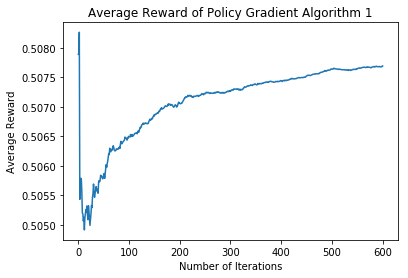

In [177]:
# Algorithm 1 testing
x1, y1 = g1.pgBatch(50, 600)

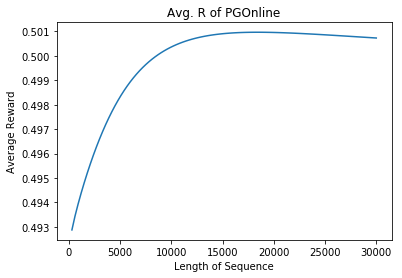

In [178]:
# Algorithm 2 testing
x2, y2 = g2.pgOnline(1e-4, 1-1e-3, 30000, 100)

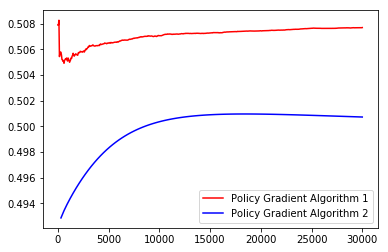

In [179]:
plt.plot([x * 50 for x in x1], y1, 'r',label="Policy Gradient Algorithm 1")
plt.plot(x2, y2, 'b', label="Policy Gradient Algorithm 2")
plt.legend()
plt.show()

In [168]:
g2.pi[48]

array([ 0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [169]:
pi_ = np.einsum('ijk,kl->ij', g2.Phi, g2.w)

In [171]:
pi_[48] - pi_[48].mean()

array([-184.26917768,  709.78458755,  -84.24289347, -180.42777722,
        -70.92325751,  -51.02809131, -110.15468339,   60.05758656,
         13.49159083, -102.28788436])

In [141]:
#np.exp(pi_ -10) / np.exp(pi_ -10).sum()

In [140]:
#np.exp(pi_ - 20) / np.exp(pi_ - 20).sum()